# Supervised machine learning

In order to limit the consequences of climate changes, major cities such as Seattle are trying to reduce their environmental impact by reducing their energy consumption as well as their greenhouse gases (GHG) emissions. To do so, the city is evaluating each year the energy consumption of each building as well as GHG emissions. Such measurements are time consuming and costly. Designing a model allowing estimating the energy consumption and GHG emissions of a building before it is even built could be a powerful tool both for environmental and economic reasons.

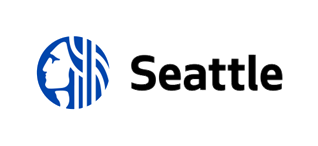

The aim of this project is to apply techniques of supervised machine learning to data provided by the city of Seattle in 2016 for predicting the energetic conception of buildings. The potential greenhouse gases emissions of the building will also be estimated with a second model. The data are available on the website for open data of the city of Seattle (<a href=https://data.Seattle.gov/dataset/2016-Building-Energy-Benchmarking/2bpz-gwpy>see</a>). The model will be limited to non-residential buildings only.

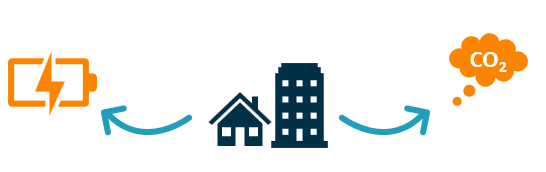

First Libraries are imported

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Custom colors for charts

c_0 = np.array([2, 48, 71,256])/256
c_1 = np.array([251, 133, 0,256])/256
c_2 = np.array([255, 183, 3,256])/256
c_3 = np.array([33, 158, 188,256])/256
c_4 = np.array([142, 202, 230,256])/256

# Creating a custom colormap
# The code comes from https://matplotlib.org/3.1.1/tutorials/colors/colormap-manipulation.html
from matplotlib.colors import ListedColormap

N = 256
vals = np.ones((N, 4))
vals[:, 0] = np.linspace(c_0[0], c_1[0], N)
vals[:, 1] = np.linspace(c_0[1], c_1[1], N)
vals[:, 2] = np.linspace(c_0[2], c_1[2], N)
custom_cmp1 = ListedColormap(vals)

# A colormap with white in the middle
N = 256
vals = np.ones((N, 4))
vals[:, 0] = np.concatenate((np.linspace(c_0[0], 1, 128), np.linspace(1, c_1[0], 128)), axis = None)
vals[:, 1] = np.concatenate((np.linspace(c_0[1], 1, 128), np.linspace(1, c_1[1], 128)), axis = None)
vals[:, 2] = np.concatenate((np.linspace(c_0[2], 1, 128), np.linspace(1, c_1[2], 128)), axis = None)
custom_cmp2 = ListedColormap(vals)

# 1. Data visualisation (features, NaN...)

First the dataset is visualized in order to get a better idea of the **size** of the dataset, the number of **missing data**...

The dataset is imported and is shape (number of samples, number of features) is displayed

In [3]:
df_raw = pd.read_csv('2016_Building_Energy_Benchmarking.csv')
df_raw.shape

(3376, 46)

The name of the featues are displayed as a list

In [4]:
list(df_raw.columns)

['OSEBuildingID',
 'DataYear',
 'BuildingType',
 'PrimaryPropertyType',
 'PropertyName',
 'Address',
 'City',
 'State',
 'ZipCode',
 'TaxParcelIdentificationNumber',
 'CouncilDistrictCode',
 'Neighborhood',
 'Latitude',
 'Longitude',
 'YearBuilt',
 'NumberofBuildings',
 'NumberofFloors',
 'PropertyGFATotal',
 'PropertyGFAParking',
 'PropertyGFABuilding(s)',
 'ListOfAllPropertyUseTypes',
 'LargestPropertyUseType',
 'LargestPropertyUseTypeGFA',
 'SecondLargestPropertyUseType',
 'SecondLargestPropertyUseTypeGFA',
 'ThirdLargestPropertyUseType',
 'ThirdLargestPropertyUseTypeGFA',
 'YearsENERGYSTARCertified',
 'ENERGYSTARScore',
 'SiteEUI(kBtu/sf)',
 'SiteEUIWN(kBtu/sf)',
 'SourceEUI(kBtu/sf)',
 'SourceEUIWN(kBtu/sf)',
 'SiteEnergyUse(kBtu)',
 'SiteEnergyUseWN(kBtu)',
 'SteamUse(kBtu)',
 'Electricity(kWh)',
 'Electricity(kBtu)',
 'NaturalGas(therms)',
 'NaturalGas(kBtu)',
 'DefaultData',
 'Comments',
 'ComplianceStatus',
 'Outlier',
 'TotalGHGEmissions',
 'GHGEmissionsIntensity']

- There is 46 features and 3376 samples in the dataset
- The targets are the following :

    **TotalGHGEmissions**
    
    **SiteEnergyUse(kBtu)**

In this project, the client requiered to study only **non-residential buildings**.Thus, the data have been filtered depending on the building type

In [5]:
list(df_raw['BuildingType'].unique())

['NonResidential',
 'Nonresidential COS',
 'Multifamily MR (5-9)',
 'SPS-District K-12',
 'Campus',
 'Multifamily LR (1-4)',
 'Multifamily HR (10+)',
 'Nonresidential WA']

In [6]:
df_raw = df_raw.drop(df_raw[(df_raw['BuildingType'] == 'Multifamily MR (5-9)')|(df_raw['BuildingType'] == 'Multifamily LR (1-4)')|(df_raw['BuildingType'] == 'Multifamily HR (10+)')].index)

The new shape of the dataset is displayed :

In [7]:
df_raw.shape

(1668, 46)

## 1.1 Missing values

In order to estimate the proportion of **missing values** (or NaN), a heatmap of the dataset is displayed

Text(0.5, 1.0, 'Heatmap of missing values')

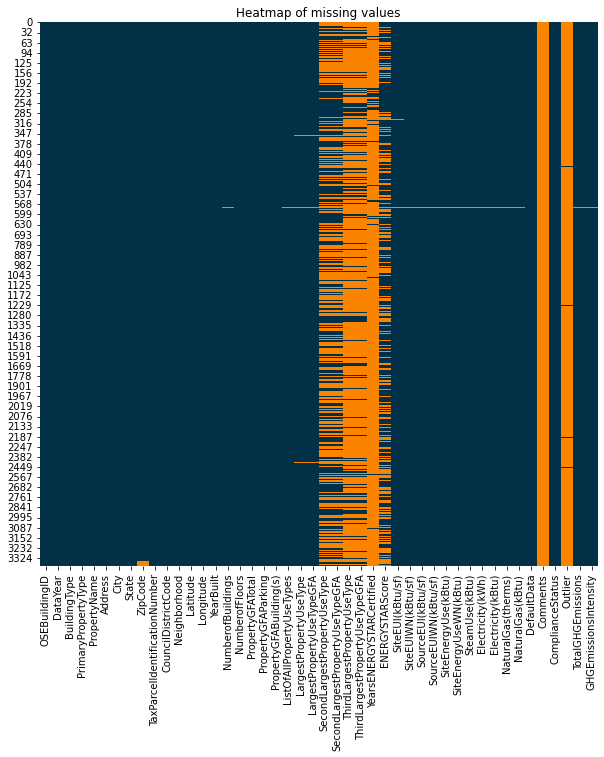

In [16]:
fig, ax = plt.subplots(figsize = (10,10))
sns.heatmap(df_raw.isna(), cbar = False, cmap = custom_cmp2, ax = ax)
ax.set_title('Heatmap of missing values')

**Missing values :**
- The following features have multiple missing data:
    - SecondLargestPropertyUseType
    - SecondLargestPropertyUseTypeGFA
    - ThirdLargestPropertyUseType
    - ThirdLargestPropertyUseTypeGFA
    - ENERGYSTARScore


- The following features have nearly all missing values:
    - YearENERGYSTARCertified
    - Comments
    - Outliers

## 1.2 Data types and distribution

The **type** of the data is observed and **data statistics** are rapidly described

In [17]:
df_raw.dtypes.value_counts()

float64    22
object     15
int64       8
bool        1
dtype: int64

In [18]:
pd.set_option('display.max_column', 46)
df_raw.describe()

OSEBuildingID  DataYear       ZipCode  CouncilDistrictCode  \
count    1668.000000    1668.0   1652.000000          1668.000000   
mean    16336.346523    2016.0  98116.819613             4.356715   
std     13835.292512       0.0     18.430353             2.191048   
min         1.000000    2016.0  98006.000000             1.000000   
25%       582.750000    2016.0  98105.000000             2.000000   
50%     21143.500000    2016.0  98109.000000             4.000000   
75%     24602.250000    2016.0  98125.000000             7.000000   
max     50226.000000    2016.0  98199.000000             7.000000   

          Latitude    Longitude    YearBuilt  NumberofBuildings  \
count  1668.000000  1668.000000  1668.000000        1666.000000   
mean     47.616054  -122.332908  1961.913669           1.168667   
std       0.048168     0.024580    32.741755           2.931409   
min      47.499170  -122.411820  1900.000000           0.000000   
25%      47.585458  -122.343280  1930.000000           1.000000   
50%      47.612340  -122.332935  1965.000000           1.000000   
75%      47.649675  -122.321675  1989.000000           1.000000   
max      47.733870  -122.258640  2015.000000         111.000000   

       NumberofFloors  PropertyGFATotal  PropertyGFAParking  \
count     1668.000000      1.668000e+03         1668.000000   
mean         4.121103      1.188427e+05        12897.979017   
std          6.563407      2.973622e+05        42274.511185   
min          0.000000      1.128500e+04            0.000000   
25%          1.000000      2.947775e+04            0.000000   
50%          2.000000      4.928950e+04            0.000000   
75%          4.000000      1.053250e+05            0.000000   
max         99.000000      9.320156e+06       512608.000000   

       PropertyGFABuilding(s)  LargestPropertyUseTypeGFA  \
count            1.668000e+03               1.662000e+03   
mean             1.059447e+05               9.876469e+04   
std              2.842116e+05               2.767111e+05   
min              3.636000e+03               5.656000e+03   
25%              2.847525e+04               2.552750e+04   
50%              4.739150e+04               4.377050e+04   
75%              9.475975e+04               9.198375e+04   
max              9.320156e+06               9.320156e+06   

       SecondLargestPropertyUseTypeGFA  ThirdLargestPropertyUseTypeGFA  \
count                       855.000000                       353.00000   
mean                      36804.160581                     14923.13994   
std                       69845.261024                     36790.55656   
min                           0.000000                         0.00000   
25%                        5350.000000                      2663.00000   
50%                       12000.000000                      5931.00000   
75%                       31881.000000                     12941.00000   
max                      686750.000000                    459748.00000   

       ENERGYSTARScore  SiteEUI(kBtu/sf)  SiteEUIWN(kBtu/sf)  \
count      1094.000000       1665.000000         1665.000000   
mean         65.449726         72.158799           74.568529   
std          28.492928         74.048129           75.028403   
min           1.000000          0.000000            0.000000   
25%          48.000000         33.700001           35.400002   
50%          73.000000         51.900002           53.900002   
75%          89.000000         81.699997           85.199997   
max         100.000000        834.400024          834.400024   

       SourceEUI(kBtu/sf)  SourceEUIWN(kBtu/sf)  SiteEnergyUse(kBtu)  \
count         1666.000000           1666.000000         1.666000e+03   
mean           175.829892            178.090876         8.437933e+06   
std            185.932121            185.918749         3.024380e+07   
min              0.000000             -2.100000         0.000000e+00   
25%             76.450001             79.325003         1.229291e+06

In [19]:
df_raw.describe(include = 'O')

BuildingType          PrimaryPropertyType PropertyName  \
count             1668                         1668         1668   
unique               5                           22         1664   
top     NonResidential  Small- and Mid-Sized Office   South Park   
freq              1460                          292            2   

                  Address     City State TaxParcelIdentificationNumber  \
count                1668     1668  1668                          1668   
unique               1647        1     1                          1587   
top     2600 SW Barton St  Seattle    WA                    1625049001   
freq                    4     1668  1668                             8   

       Neighborhood ListOfAllPropertyUseTypes LargestPropertyUseType  \
count          1668                      1666                   1662   
unique           19                       373                     56   
top        DOWNTOWN                    Office                 Office   
freq            361                       138                    497   

       SecondLargestPropertyUseType ThirdLargestPropertyUseType  \
count                           855                         353   
unique                           47                          39   
top                         Parking                      Office   
freq                            336                          49   

       YearsENERGYSTARCertified ComplianceStatus      Outlier  
count                        98             1668           17  
unique                       64                4            2  
top                        2016        Compliant  Low outlier  
freq                         12             1548           15

Data Types
- The data are either:
    - Float64 (22/46)
    - Int64 (8/46)
    - Bool (1/46)
    - Object (15/46)


**Histograms** are built in order to better apprehend the **data distribution**

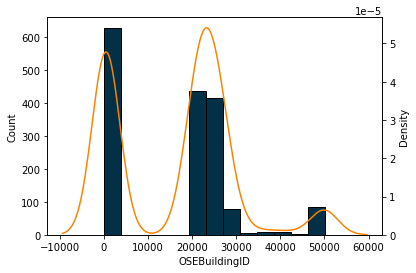

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)


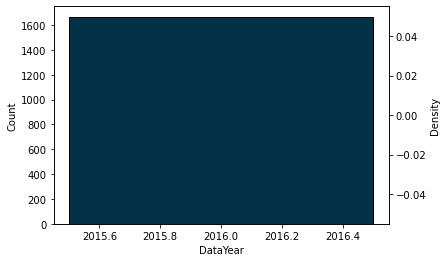

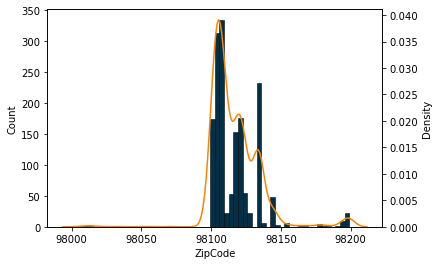

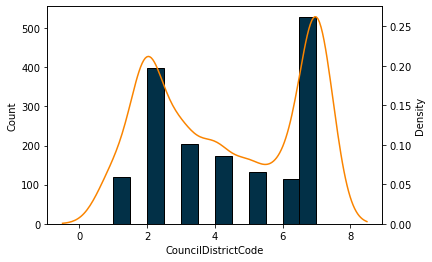

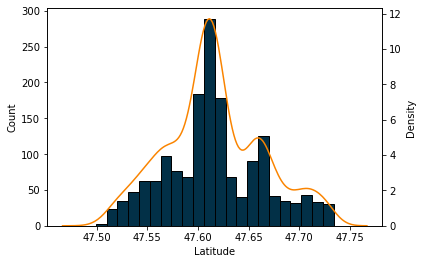

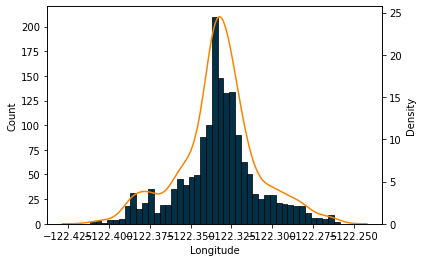

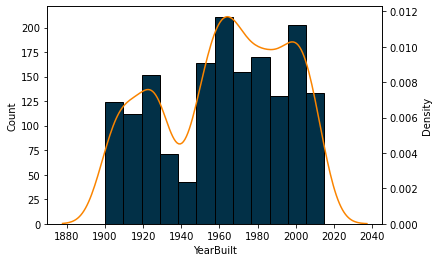

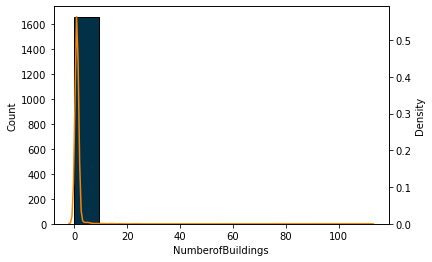

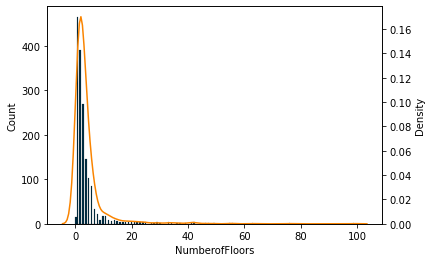

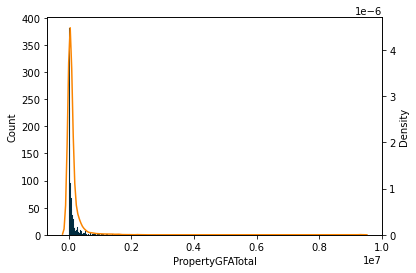

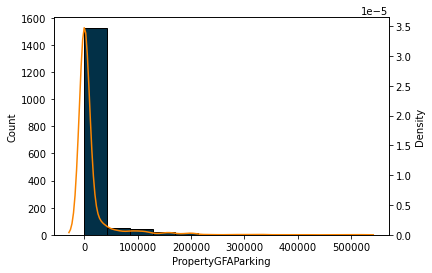

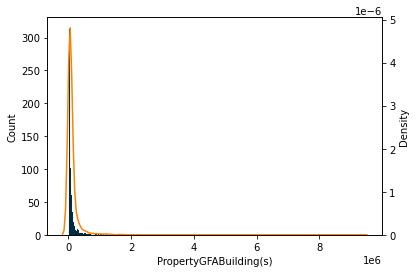

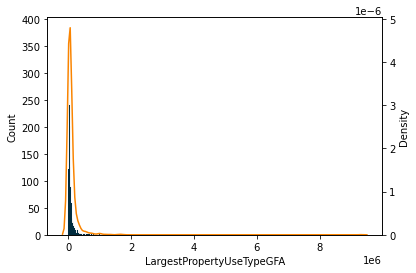

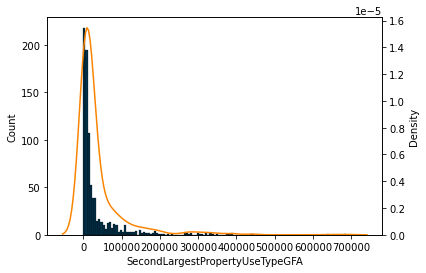

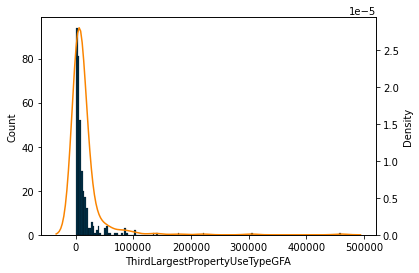

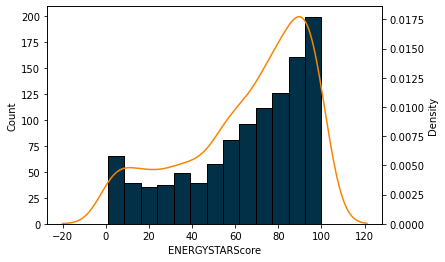

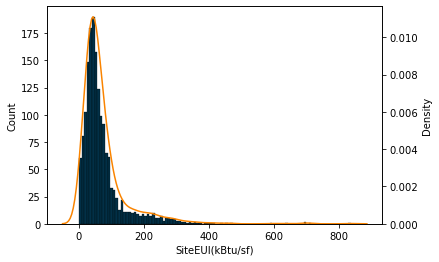

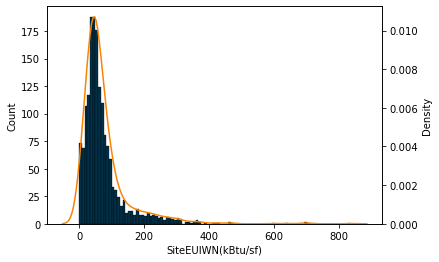

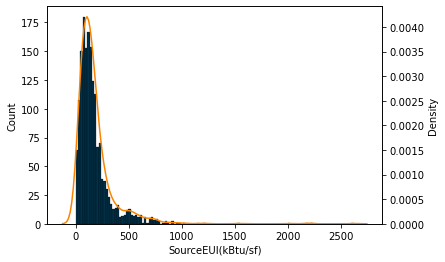

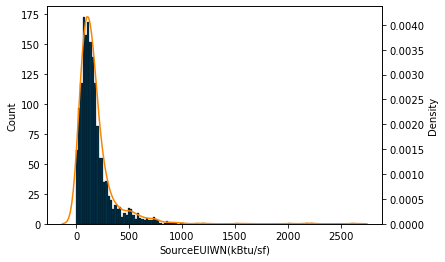

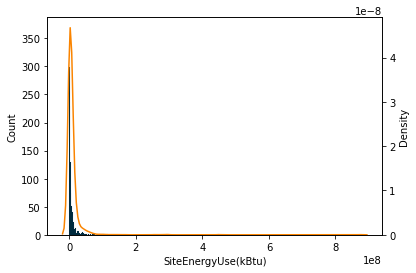

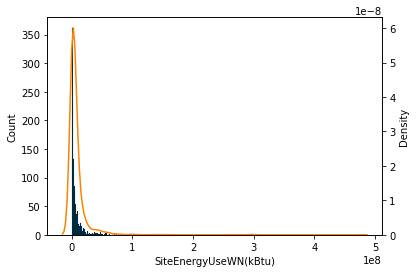

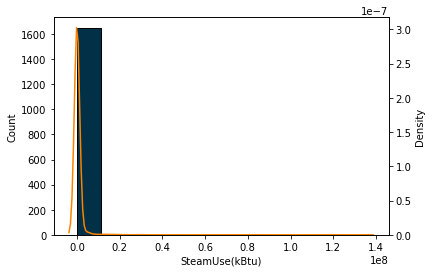

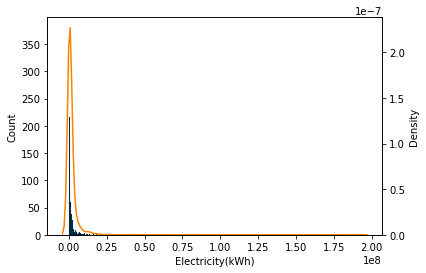

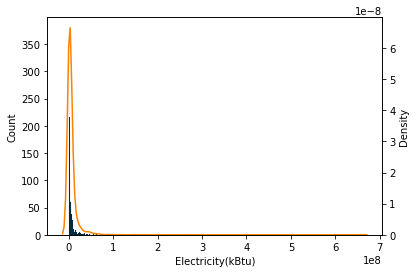

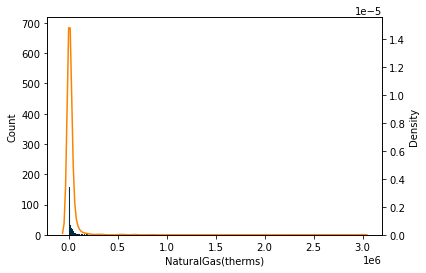

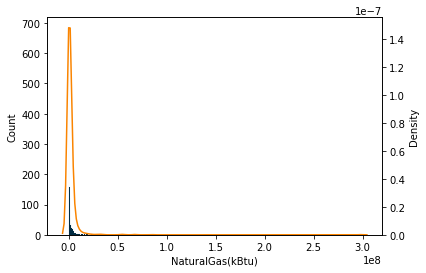

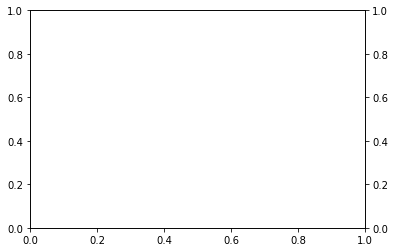

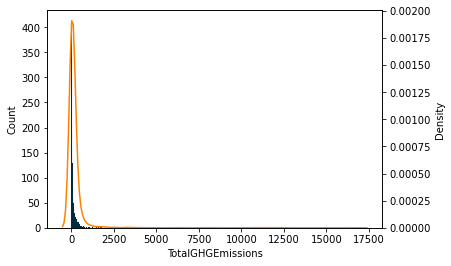

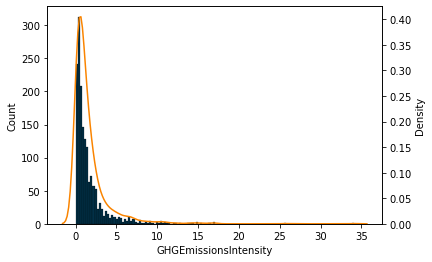

In [13]:
for col in df_raw.select_dtypes(exclude = ['O', bool]):
    sns.histplot(data = df_raw, x = col, color = c_0, alpha = 1)
    ax2 = plt.twinx()
    sns.kdeplot(data = df_raw, x = col, color = c_1, alpha = 1, ax = ax2)
    plt.show()

Some features seems to be better visualised on a **log scale**. These features are placed in a list called *log_list*.

In [20]:
log_list = ['NumberofBuildings',
'NumberofFloors',
'PropertyGFATotal',
'PropertyGFAParking',
'PropertyGFABuilding(s)',
'LargestPropertyUseTypeGFA',
'SecondLargestPropertyUseTypeGFA',
'ThirdLargestPropertyUseTypeGFA',
'SiteEUI(kBtu/sf)',
'SiteEUIWN(kBtu/sf)',
'SourceEUI(kBtu/sf)',
'SourceEUIWN(kBtu/sf)',
'SiteEnergyUse(kBtu)',
'SiteEnergyUseWN(kBtu)',
'SteamUse(kBtu)',
'Electricity(kWh)',
'Electricity(kBtu)',
'NaturalGas(therms)',
'NaturalGas(kBtu)',
'TotalGHGEmissions',
'GHGEmissionsIntensity']

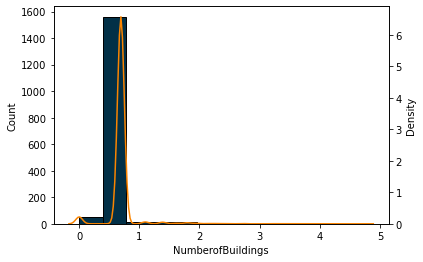

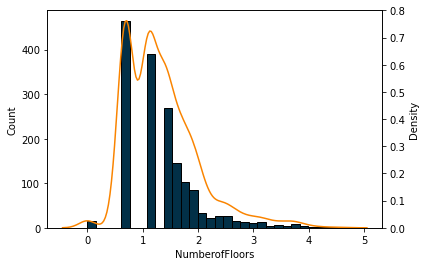

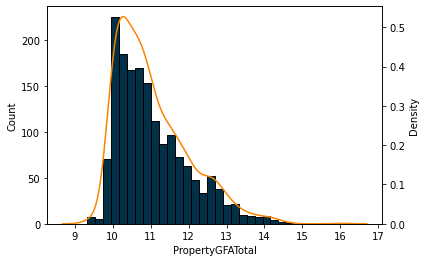

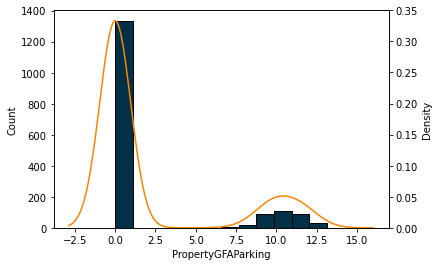

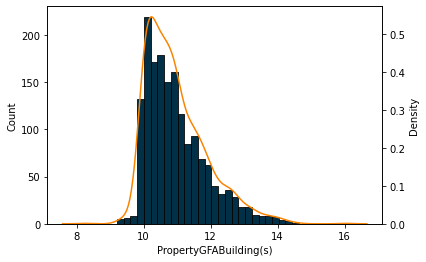

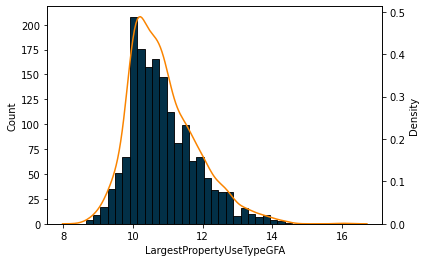

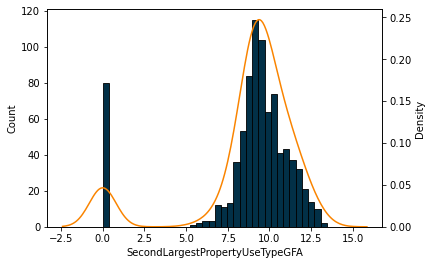

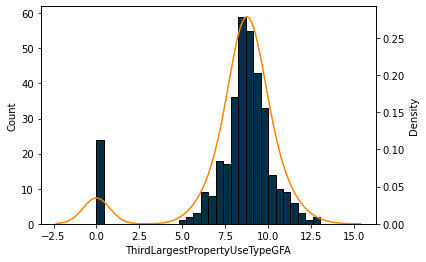

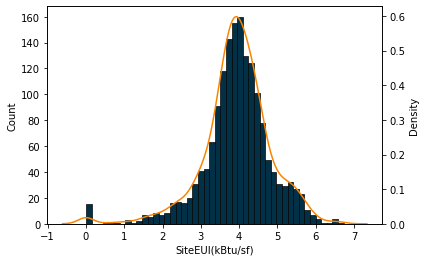

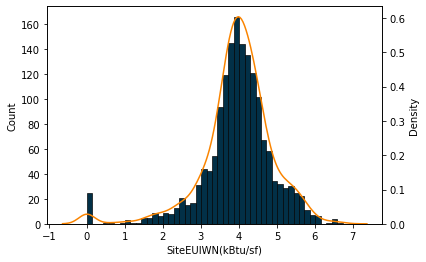

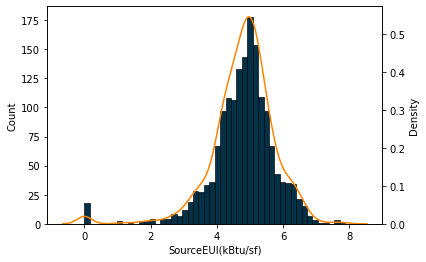

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arraylike.py:397: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arraylike.py:397: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)


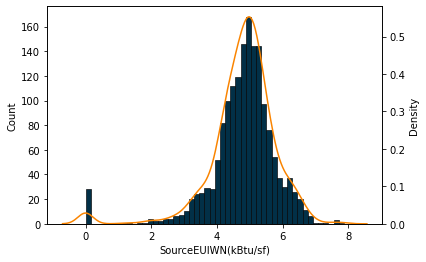

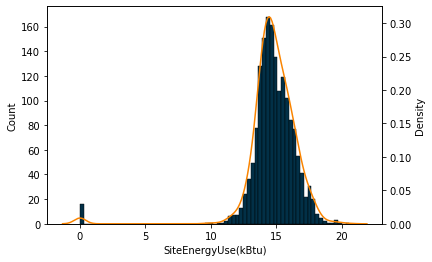

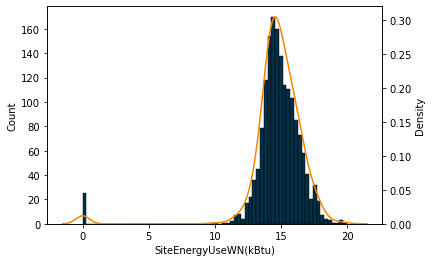

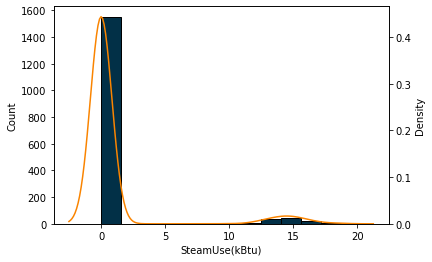

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arraylike.py:397: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arraylike.py:397: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)


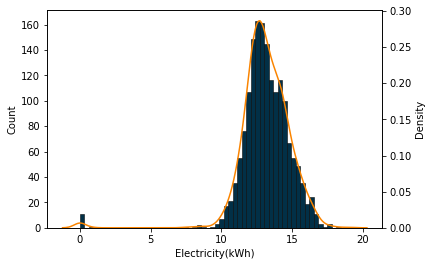

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arraylike.py:397: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arraylike.py:397: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)


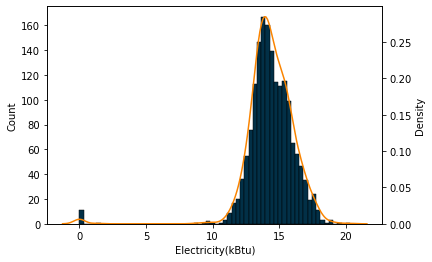

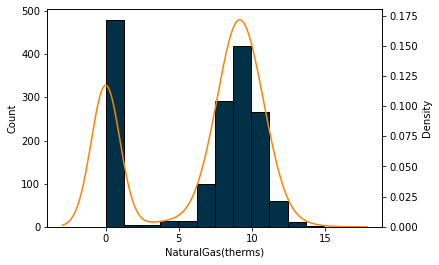

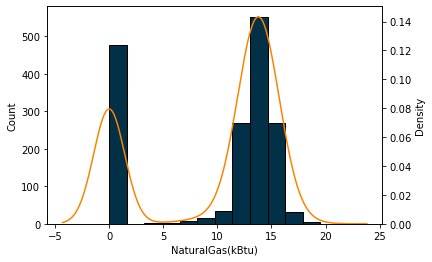

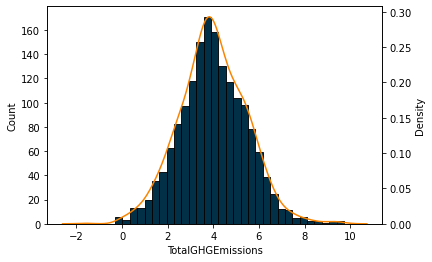

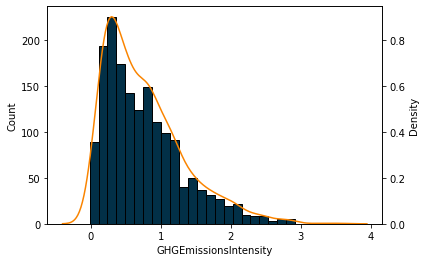

In [15]:
for col in log_list:
    sns.histplot(x = np.log1p(df_raw[col]), color = c_0, alpha = 1)
    ax2 = plt.twinx()
    sns.kdeplot(x = np.log1p(df_raw[col]), color = c_1, alpha = 1, ax = ax2)
    plt.show()

## 1.3 Features correlation

Features could be correlated to the target, allowing building a robust model. However, features could be correlated with each other, possibly leading to issues in the building of a machine learning model. Moreover, highly correlated features allow removing non-relevant features. Correlations between the features and targets are looked at in a correlation matrix.

Text(0.5, 1.0, 'Correlation matrix')

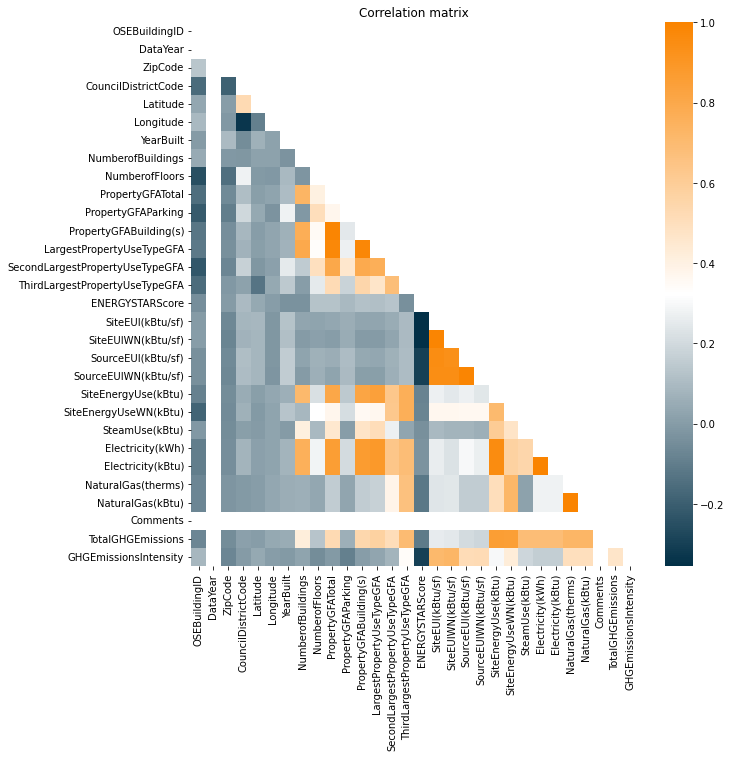

In [21]:
corr_matrix = df_raw.select_dtypes(include = np.number).corr()

fig, ax = plt.subplots(figsize = (10,10))

mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
sns.heatmap(corr_matrix, mask = mask, cmap = custom_cmp2)
ax.set_title('Correlation matrix')

Text(0.5, 1.0, 'Correlation matrix')

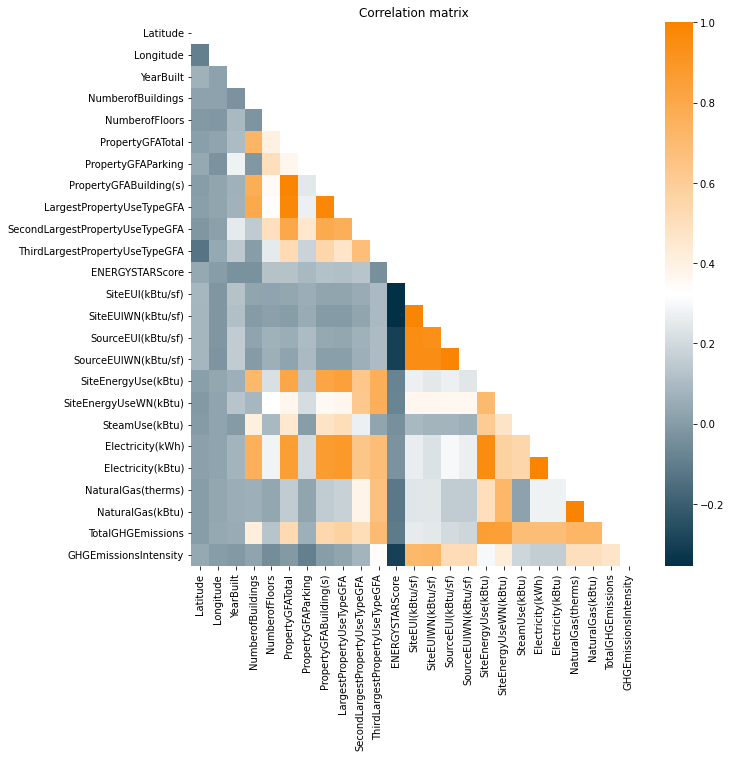

In [22]:
# Draw a correlation matrix only for data selected as "relevant"

select_list = ['Latitude','Longitude','YearBuilt','NumberofBuildings','NumberofFloors','PropertyGFATotal','PropertyGFAParking','PropertyGFABuilding(s)','LargestPropertyUseTypeGFA','SecondLargestPropertyUseTypeGFA','ThirdLargestPropertyUseTypeGFA','ENERGYSTARScore','SiteEUI(kBtu/sf)','SiteEUIWN(kBtu/sf)','SourceEUI(kBtu/sf)','SourceEUIWN(kBtu/sf)','SiteEnergyUse(kBtu)','SiteEnergyUseWN(kBtu)','SteamUse(kBtu)','Electricity(kWh)','Electricity(kBtu)','NaturalGas(therms)','NaturalGas(kBtu)','TotalGHGEmissions','GHGEmissionsIntensity']

corr_matrix = df_raw[select_list].corr()

fig, ax = plt.subplots(figsize = (10,10))

mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
sns.heatmap(corr_matrix, mask = mask, cmap = custom_cmp2)
ax.set_title('Correlation matrix')

**Features correlation**:
- Multiple values seems correlated
    - The correlation is extreme for some values : they probably carry the same information (sometimes just with different units)
    
**Data that could be redundant** 
    
- *PropertyGFABuilding(s) - LargestPropertyUseTypeGFA - PropertyGFATotal*
- *SiteEUI(kBtu/sf) - SiteEUIWN(kBtu/sf) - SourceEUI(kBtu/sf)*
- *SiteEnergyUse(kBtu) - Electricity(kWh) - Electricity(kBtu)*
- *NaturalGas(kBtu)- NaturalGas(therms)*
    

# 2. Feature engineering

Features can be egineered and transformed in the aim of obtaining relevant information for the predictive model.

## 2.1 Using the buildings location

The building location could be correlated to the building energetic consumption and GHG emission. In order to assess this hypothesis, features are displayed on a map in order to identify patterns.

In [26]:
import folium # For creating interactive maps

def color_circle(df):
    '''
    Function for setting the color of dot depending on a given parameter
    '''
    from matplotlib import cm
    from matplotlib.colors import rgb2hex

    n_items = df.nunique() # Search the number of items
    #color_list = cm.get_cmap('nipy_spectral')(np.linspace(0, 1, n_items)) # Create a list-like colormap for the number of items
    color_list = custom_cmp2(np.linspace(0, 1, n_items)) # Create a list-like colormap for the number of items

    color_dict = {} # Create a dict 'item' : 'color'
    for index, value in np.ndenumerate(np.sort(df.unique())):

        color_hex = rgb2hex(color_list[index[0]-1]) # Folium is taking Hex color values
        color_dict[value] = color_hex

    return df.map(color_dict)

In [27]:
def size_circle(df):
    '''
    Function for setting the size of dot depending on a given parameter
    '''

    n_items = df.nunique() # Search the number of items
    
    size_list = np.linspace(10, 150, n_items) # Create a list of size for the number of items

    size_dict = {} # Create a dict 'item' : 'color'
    for index, value in np.ndenumerate(np.sort(df.unique())):

        size_dict[value] = size_list[index[0]-1]

    return df.map(size_dict)

<b><span style="color:#FB8500">/!\ For keeping the weight of the EDA file resonnable, the interactive maps generated from folium have been replaced with images</span></b>

**Representing buildings with color as a function of the neighborhood**

In [ ]:
seattle_coo = [47.605083, -122.317015] # Where to start the map
loc_map = folium.Map(location=seattle_coo, zoom_start= 10) # Creating the map
color = color_circle(df_raw['Neighborhood']) # Creating colors to color the neighborhoods
size = size_circle(df_raw['Neighborhood']) # Creating sizes for the neighborhoods

for index, value in df_raw.iterrows():
    place_coo = [value['Latitude'], value['Longitude']]
    circle = folium.Circle(place_coo,
                           radius=10,
                           color=color.loc[index],
                           fill=True).add_child(folium.Popup(value['Neighborhood']))
    loc_map.add_child(circle)


loc_map

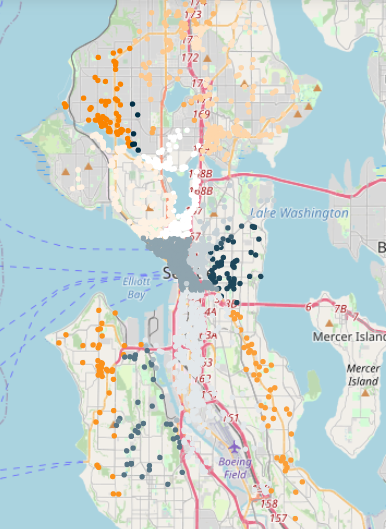

Some Neighborhoods name are in capitals and other not, thus the data are consolidated.

In [29]:
df_raw.loc[:,'Neighborhood'] = df_raw.loc[:,'Neighborhood'].str.upper()

**Map representing buildings colored as a function of the electricity consumption**

In [ ]:
seattle_coo = [47.605083, -122.317015] # Where to start the map
loc_map = folium.Map(location=seattle_coo, zoom_start=11) # Creating the map
color = color_circle(df_raw['Electricity(kWh)']) # Creating colors to color the neighborhoods
size = size_circle(df_raw['Electricity(kWh)']) # Creating sizes for the neighborhoods

for index, value in df_raw.iterrows():
    place_coo = [value['Latitude'], value['Longitude']]
    circle = folium.Circle(place_coo,
                           radius=size.loc[index],
                           color=color.loc[index],
                           weight = 1,
                           fill=True).add_child(folium.Popup(str(value['Electricity(kWh)'])))
    loc_map.add_child(circle)

loc_map

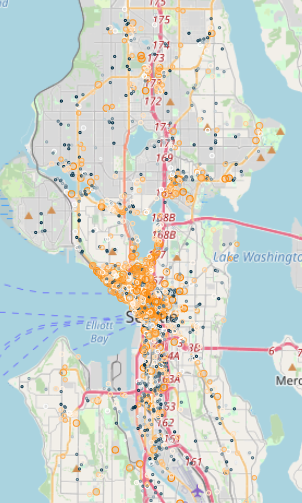

**Map representing buildings colored as a function of the total GHG emmisions**

In [ ]:
seattle_coo = [47.605083, -122.317015] # Where to start the map
loc_map = folium.Map(location=seattle_coo, zoom_start=11) # Creating the map
color_cicle = color_circle(df_raw['TotalGHGEmissions']) # Creating colors to color the neighborhoods

for index, value in df_raw.iterrows():
    place_coo = [value['Latitude'], value['Longitude']]
    circle = folium.Circle(place_coo, radius=10, color=color_cicle.loc[index], fill=True).add_child(folium.Popup(str(value['TotalGHGEmissions'])))
    loc_map.add_child(circle)

loc_map

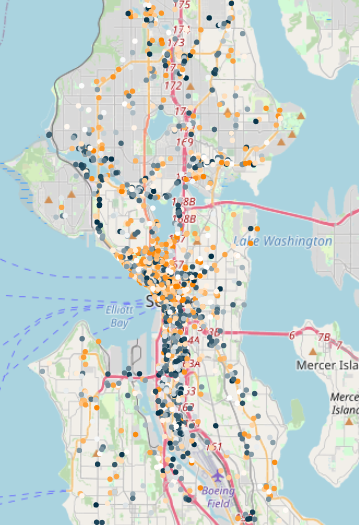

**Map representing buildings colored as a function of the steam use**

In [ ]:
seattle_coo = [47.605083, -122.317015] # Where to start the map
loc_map = folium.Map(location=seattle_coo, zoom_start=11) # Creating the map
color_cicle = color_circle(df_raw['SteamUse(kBtu)']) # Creating colors to color the neighborhoods

for index, value in df_raw.iterrows():
    place_coo = [value['Latitude'], value['Longitude']]
    circle = folium.Circle(place_coo, radius=10, color=color_cicle.loc[index], fill=True).add_child(folium.Popup(str(value['SteamUse(kBtu)'])))
    loc_map.add_child(circle)

loc_map

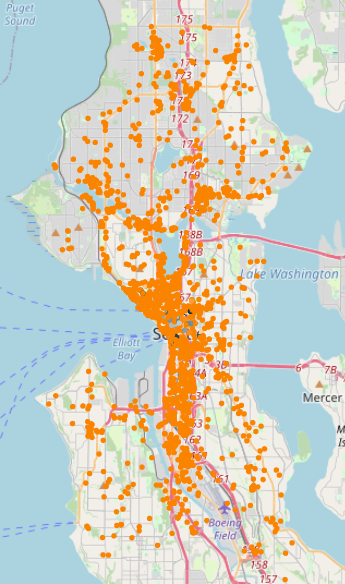

**Map representing buildings colored as a function of the year the building was built**

In [ ]:
seattle_coo = [47.605083, -122.317015] # Where to start the map
loc_map = folium.Map(location=seattle_coo, zoom_start=11) # Creating the map
color_cicle = color_circle(df_raw['YearBuilt']) # Creating colors to color the neighborhoods

for index, value in df_raw.iterrows():
    place_coo = [value['Latitude'], value['Longitude']]
    circle = folium.Circle(place_coo, radius=10, color=color_cicle.loc[index], fill=True).add_child(folium.Popup(str(value['YearBuilt'])))
    loc_map.add_child(circle)

loc_map

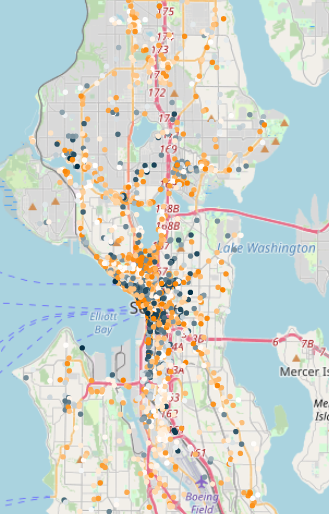

**Map representing buildings colored as a function of the number of floors**

In [ ]:
seattle_coo = [47.605083, -122.317015] # Where to start the map
loc_map = folium.Map(location=seattle_coo, zoom_start=11) # Creating the map
color_cicle = color_circle(df_raw['NumberofFloors']) # Creating colors to color the neighborhoods

for index, value in df_raw.iterrows():
    place_coo = [value['Latitude'], value['Longitude']]
    circle = folium.Circle(place_coo, radius=10, color=color_cicle.loc[index], fill=True).add_child(folium.Popup(str(value['NumberofFloors'])))
    loc_map.add_child(circle)

loc_map

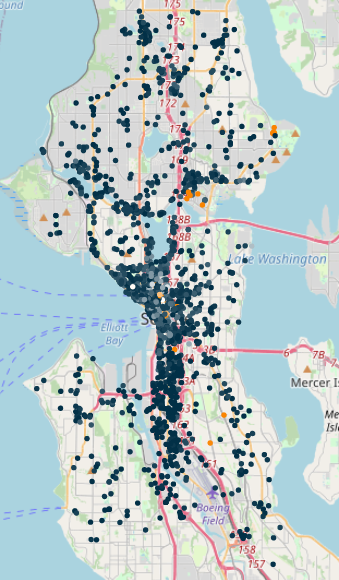

It appears that some features as *Number of floors* and the target related to the energy consumption as well as the GHG emissions and are correlated to the location of the buildings. Moreover, it seems that they could be related to the proximity of these buildings with the city center (indicated by the Downtown neighborhood).

Thus, the distance from the downtown centroid has been calculated and added to the dataset.

**Map representing buildings colored as a function of the distance is then displayed**

In [ ]:
# Get the distance from the downtown centroid
# This function comes from a previous project and have been provided by IBM through the
# Program 'Python Data Science' https://www.edx.org/professional-certificate/ibm-python-data-science

def calculate_distance(lat1, lon1, lat2, lon2):
    # approximate radius of earth in km
    R = 6373.0

    lat1 = np.radians(lat1)
    lon1 = np.radians(lon1)
    lat2 = np.radians(lat2)
    lon2 = np.radians(lon2)

    dlon = lon2 - lon1
    dlat = lat2 - lat1

    a = np.sin(dlat / 2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))

    distance = R * c
    return distance


# Centroid of the Downtown
downtown_center = [df_raw.groupby('Neighborhood').mean()['Latitude'].loc['DOWNTOWN'],
            df_raw.groupby('Neighborhood').mean()['Longitude'].loc['DOWNTOWN']]


# Calculate the distance from the downtown center and add it to the DataFrame
distance = calculate_distance(np.full((df_raw['Latitude'].shape), downtown_center[0]),
                              np.full((df_raw['Latitude'].shape), downtown_center[1]),
                              df_raw['Latitude'],
                              df_raw['Longitude'])
    

df_raw['distance(km)'] = distance

color_cicle = color_circle(df_raw['distance(km)']) # Creating colors to color the neighborhoods

seattle_coo = [47.605083, -122.317015] # Where to start the map
loc_map = folium.Map(location=seattle_coo, zoom_start=11) # Creating the map

for index, value in df_raw.iterrows():
    place_coo = [value['Latitude'], value['Longitude']]
    circle = folium.Circle(place_coo, radius=10, color=color_cicle.loc[index], fill=True).add_child(folium.Popup(str(value['distance(km)'])))
    loc_map.add_child(circle)

loc_map

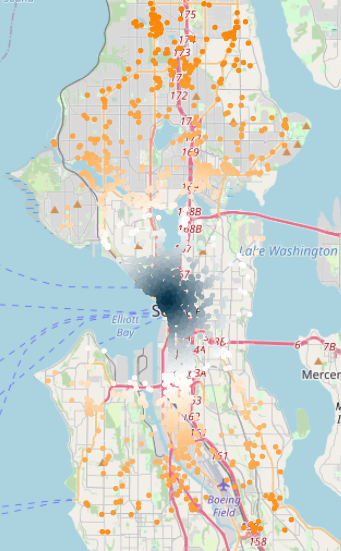

## 2.2 The street type

The street type (avenue, road...) could give an indication about the function or the importance of a given building and thus could inform about the building environmental impact. Street suffixes are extracted from the addresses and used to add the street type as a new feature in the dataset.

**A map representing buildings colored as a function of the street type is then displayed**

In [36]:
# Create a dict of suffix based on the data from US postal office https://pe.usps.com/text/pub28/28apc_002.htm

suffix_dict = {'avenue' : 'ave',
               'street' : 'st',
               'way' : 'way',
               'boulevard' : 'Blvd',
              'road' : 'rd'}


def address_to_suffix(data):
    for key in suffix_dict.keys():
        if suffix_dict[key].lower() in data.lower():
            return key.lower()
            break

df_raw['streetType'] = list(map(address_to_suffix, df_raw['Address']))

df_raw.loc[df_raw['streetType'].isna(), 'streetType'] = 'street'

In [ ]:
seattle_coo = [47.605083, -122.317015] # Where to start the map
loc_map = folium.Map(location=seattle_coo, zoom_start= 10) # Creating the map
color_cicle = color_circle(df_raw['streetType']) # Creating colors to color the neighborhoods

for index, value in df_raw.iterrows():
    place_coo = [value['Latitude'], value['Longitude']]
    circle = folium.Circle(place_coo, radius=10, color=color_cicle.loc[index], fill=True).add_child(folium.Popup(value['streetType']))
    loc_map.add_child(circle)


loc_map

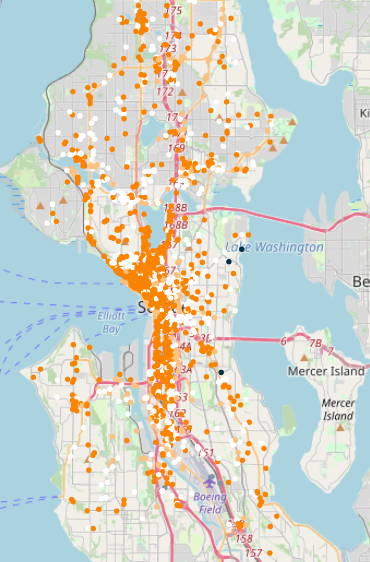

## 2.3 The energy mix

*SteamUse(kBtu), Electricity(kBtu)* and *NaturalGas(kBtu)* can't be used by the model for prediction (as it would be considered as data leakage). However, these features allow estimating the energy mix of a given building (the proportion of each type of energy used by the building). This information is available when the building is being built and is therefore not considered as data leakage.

The different energy uses are divided by the total energy use. As the sum of the energy is not always equal to SiteEnergyUse, there is another energy type that is not considered.Thus, a fourth energy type is added to the features.

In [38]:
other_energy_type = df_raw['SiteEnergyUse(kBtu)'] - (df_raw['Electricity(kBtu)'] + df_raw['NaturalGas(kBtu)'] + df_raw['SteamUse(kBtu)'])

Definition of the electricity proportion

In [39]:
df_raw['ElectricityProp'] = df_raw['Electricity(kBtu)']/df_raw['SiteEnergyUse(kBtu)']

Definition of the natural gas proportion

In [40]:
df_raw['NaturalGasProp'] = df_raw['NaturalGas(kBtu)']/df_raw['SiteEnergyUse(kBtu)']

Definition of the steam proportion

In [41]:
df_raw['SteamProp'] = df_raw['SteamUse(kBtu)']/df_raw['SiteEnergyUse(kBtu)']

Definition of other energy type the steam proportion

In [42]:
df_raw['OtherEnergyProp'] = other_energy_type/df_raw['SiteEnergyUse(kBtu)']

# 3. Data Cleanning

After studying exploring the dataset, the data are cleaned in order to avoid missing data and outliers.

The clean dataset is called df

In [52]:
df = df_raw.copy()

## 3.1 Duplicates

**Duplicates** are addressed

In [44]:
df_raw.duplicated(subset = ['PropertyName', 'Address']).sum()

0

No duplicates based on Property Name and Address have been identified

## 3.2 Missing values

**Missing values** (NaN) are addressed

In [45]:
# Estimation of the proportion of NaN
df.isna().sum(axis=0)

OSEBuildingID                         0
DataYear                              0
BuildingType                          0
PrimaryPropertyType                   0
PropertyName                          0
Address                               0
City                                  0
State                                 0
ZipCode                              16
TaxParcelIdentificationNumber         0
CouncilDistrictCode                   0
Neighborhood                          0
Latitude                              0
Longitude                             0
YearBuilt                             0
NumberofBuildings                     2
NumberofFloors                        0
PropertyGFATotal                      0
PropertyGFAParking                    0
PropertyGFABuilding(s)                0
ListOfAllPropertyUseTypes             2
LargestPropertyUseType                6
LargestPropertyUseTypeGFA             6
SecondLargestPropertyUseType        813
SecondLargestPropertyUseTypeGFA     813


Samples with NaN in LargestPropertyUseType, SiteEnergyUse(kBtu), ElectricityProp, NaturalGasProp and SteamProp as NaN are droped

In [53]:
df = df.dropna(subset = ['SiteEnergyUse(kBtu)', 'ElectricityProp', 'NaturalGasProp', 'SteamProp', 'LargestPropertyUseType'])
df.shape

(1646, 52)

NaN is SecondLargestPropertyUseType and ThirdLargestPropertyUseType will be replaced by 'None'

NaN in the corresponding surfaces will be replaced by 0

In [54]:
# NaN is SecondLargestPropertyUseType and ThirdLargestPropertyUseType will be replaced by 'None'
# NaN in the corresponding surfaces will be replaced by 0

df = df.fillna({'SecondLargestPropertyUseType':'None',
                'ThirdLargestPropertyUseType':'None',
                'SecondLargestPropertyUseTypeGFA': 0,
                'ThirdLargestPropertyUseTypeGFA':0})

The number of missing values **for each features** is displayed after the cleaning :

In [55]:
df.isna().sum(axis=0)

OSEBuildingID                         0
DataYear                              0
BuildingType                          0
PrimaryPropertyType                   0
PropertyName                          0
Address                               0
City                                  0
State                                 0
ZipCode                              16
TaxParcelIdentificationNumber         0
CouncilDistrictCode                   0
Neighborhood                          0
Latitude                              0
Longitude                             0
YearBuilt                             0
NumberofBuildings                     0
NumberofFloors                        0
PropertyGFATotal                      0
PropertyGFAParking                    0
PropertyGFABuilding(s)                0
ListOfAllPropertyUseTypes             0
LargestPropertyUseType                0
LargestPropertyUseTypeGFA             0
SecondLargestPropertyUseType          0
SecondLargestPropertyUseTypeGFA       0


The samples with NaN droped also appeared to have NaN as 'NumberofBuilding'

All NaN have been adressed except for ZipCode, YearsENERGYSTARCertified, ENERGYSTARScore, Comments and Outlier that will not be used is a first step

## 3.3 Outliers

**Outliers** are addressed.

In [58]:
df.describe().loc[['min', 'max']]

OSEBuildingID  DataYear  ZipCode  CouncilDistrictCode  Latitude  \
min            1.0    2016.0  98006.0                  1.0  47.49917   
max        50226.0    2016.0  98199.0                  7.0  47.73387   

     Longitude  YearBuilt  NumberofBuildings  NumberofFloors  \
min -122.41182     1900.0                0.0             0.0   
max -122.25864     2015.0              111.0            99.0   

     PropertyGFATotal  PropertyGFAParking  PropertyGFABuilding(s)  \
min           11285.0                 0.0                  3636.0   
max         9320156.0            512608.0               9320156.0   

     LargestPropertyUseTypeGFA  SecondLargestPropertyUseTypeGFA  \
min                     5656.0                              0.0   
max                  9320156.0                         639931.0   

     ThirdLargestPropertyUseTypeGFA  ENERGYSTARScore  SiteEUI(kBtu/sf)  \
min                             0.0              1.0          0.700000   
max                        459748.0            100.0        834.400024   

     SiteEUIWN(kBtu/sf)  SourceEUI(kBtu/sf)  SourceEUIWN(kBtu/sf)  \
min            0.000000                 0.0                  -2.1   
max          834.400024              2620.0                2620.0   

     SiteEnergyUse(kBtu)  SiteEnergyUseWN(kBtu)  SteamUse(kBtu)  \
min         1.680890e+04                    0.0             0.0   
max         8.739237e+08            471613856.0     134943456.0   

     Electricity(kWh)  Electricity(kBtu)  NaturalGas(therms)  \
min     -3.382680e+04          -115417.0                 0.0   
max      1.925775e+08        657074389.0           2979090.0   

     NaturalGas(kBtu)  Comments  TotalGHGEmissions  GHGEmissionsIntensity  \
min               0.0       NaN              -0.80                  -0.02   
max       297909000.0       NaN           16870.98                  34.09   

     distance(km)  ElectricityProp  NaturalGasProp  SteamProp  OtherEnergyProp  
min      0.051246        -0.336762             0.0   0.000000        -0.237346  
max     14.106772         1.000011             1.0   0.766987         1.336762

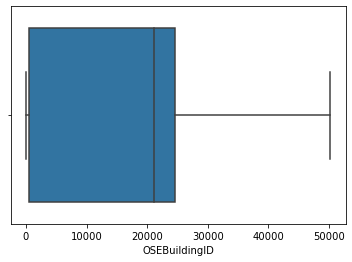

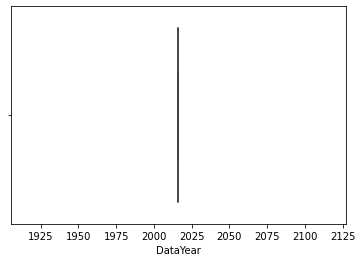

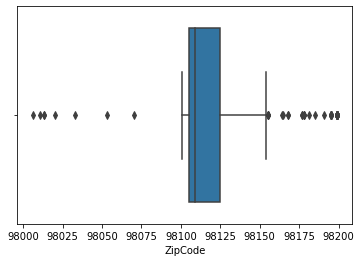

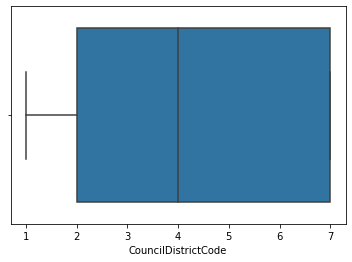

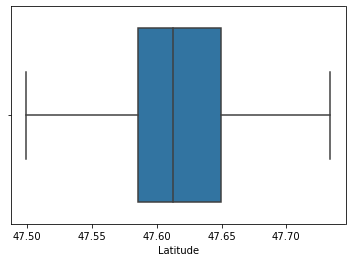

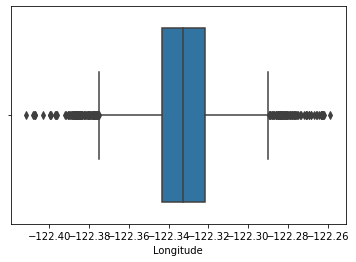

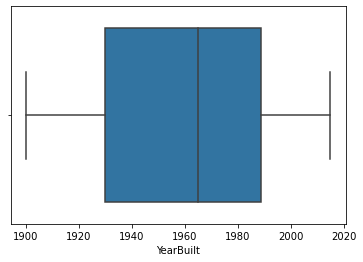

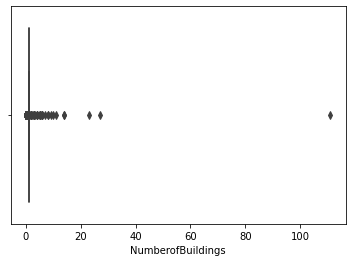

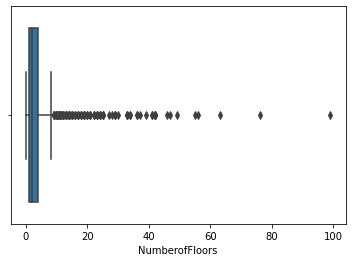

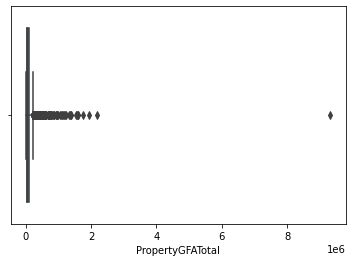

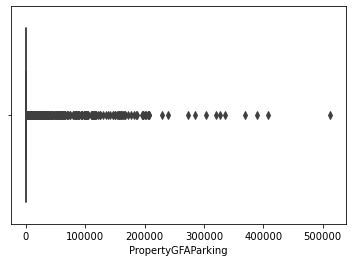

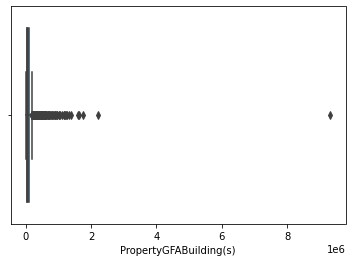

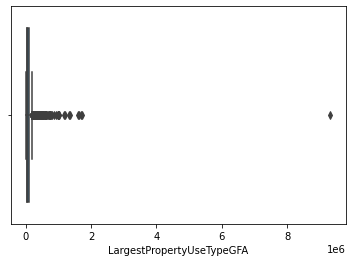

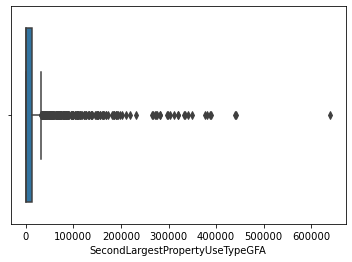

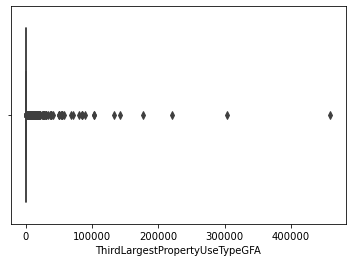

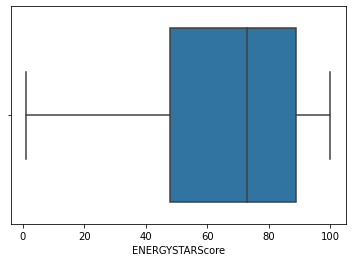

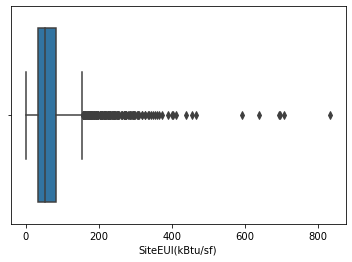

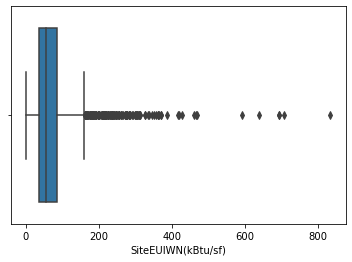

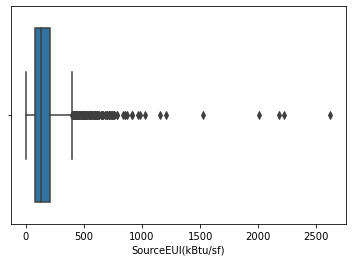

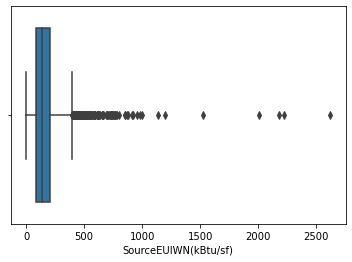

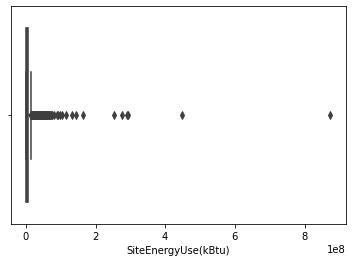

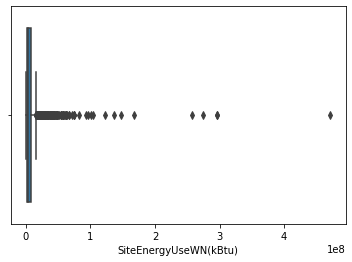

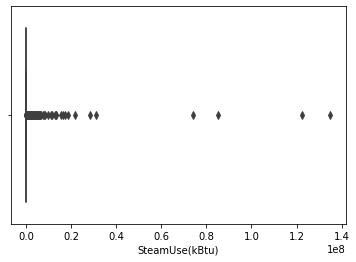

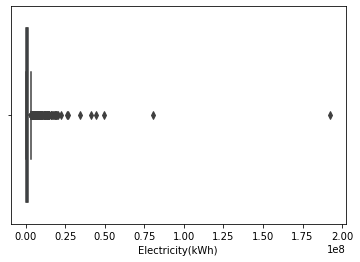

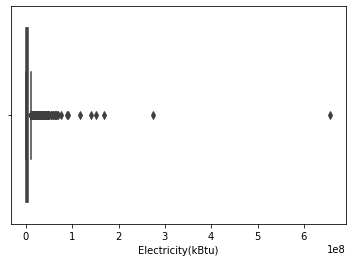

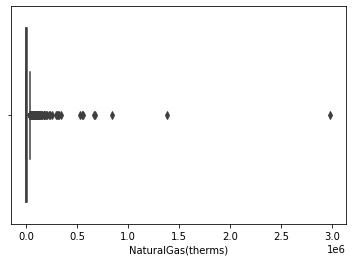

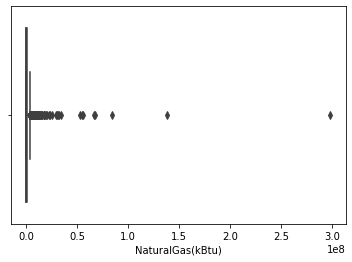

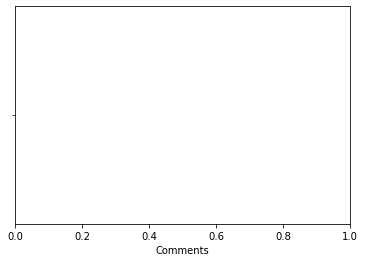

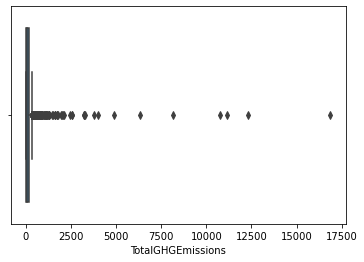

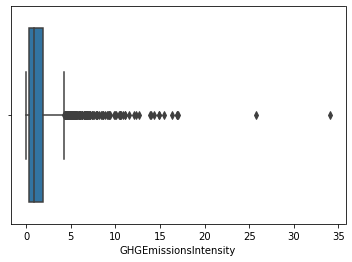

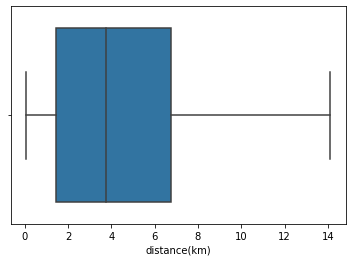

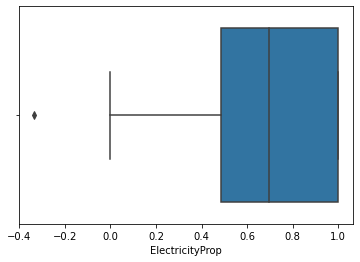

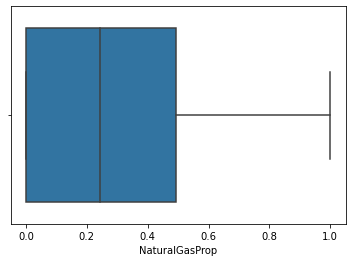

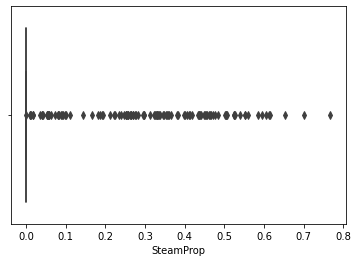

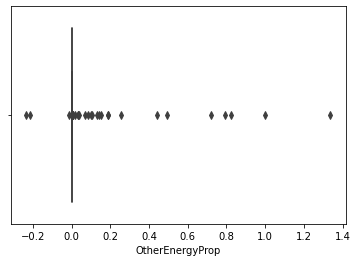

In [59]:
for col in df.select_dtypes(exclude = ['O', bool]):
    sns.boxplot(data = df, x = col)
    plt.show()

Certain buildings have an usual high *SiteEnergyUse(kBtu)*, they are checked

In [60]:
df_raw[df_raw['SiteEnergyUse(kBtu)'] > 2E8]

OSEBuildingID  DataYear    BuildingType PrimaryPropertyType  \
35               43      2016          Campus  Mixed Use Property   
124             198      2016  NonResidential            Hospital   
170             276      2016  NonResidential            Hospital   
558             753      2016  NonResidential               Other   
618             828      2016  NonResidential            Hospital   
3274          49967      2016          Campus          University   

                                   PropertyName                    Address  \
35                                 Plant 2 Site      7755 E MARGINAL WAY S   
124     Seattle Children's Hospital Main Campus     4800 Sand Point Way NE   
170                   Harborview Medical Center               325 9th Ave.   
558                              WestinBuilding               2001 6th Ave   
618                          Swedish First Hill               747 Broadway   
3274  University of Washington - Seattle Campus  NE 45th St & Brooklyn Ave   

         City State  ZipCode TaxParcelIdentificationNumber  \
35    Seattle    WA  98108.0                    0022000005   
124   Seattle    WA  98105.0                    2982800005   
170   Seattle    WA  98104.0                    8590900220   
558   Seattle    WA  98121.0                    0659000950   
618   Seattle    WA  98122.0                    1978201096   
3274  Seattle    WA  98105.0                    1625049001   

      CouncilDistrictCode      Neighborhood   Latitude   Longitude  YearBuilt  \
35                      2  GREATER DUWAMISH  47.534930 -122.317880       1992   
124                     4         NORTHEAST  47.662310 -122.281460       1953   
170                     3              EAST  47.603990 -122.323770       2000   
558                     7          DOWNTOWN  47.614380 -122.338710       1981   
618                     3              EAST  47.608951 -122.322402       1994   
3274                    4         NORTHEAST  47.656440 -122.310410       1900   

      NumberofBuildings  NumberofFloors  PropertyGFATotal  PropertyGFAParking  \
35                  1.0               3            494835                   0   
124                 6.0              10            879000                   0   
170                 9.0               8           1158691                   0   
558                 1.0              33            429405                   0   
618                 7.0              14           1765970                   0   
3274              111.0               0           9320156                   0   

      PropertyGFABuilding(s)  \
35                    494835   
124                   879000   
170                  1158691   
558                   429405   
618                  1765970   
3274                 9320156   

                              ListOfAllPropertyUseTypes  \
35    Energy/Power Station, Laboratory, Manufacturin...   
124               Hospital (General Medical & Surgical)   
170      Hospital (General Medical & Surgical), Parking   
558                                 Data Center, Office   
618      Hospital (General Medical & Surgical), Parking   
3274                                 College/University   

                     LargestPropertyUseType  LargestPropertyUseTypeGFA  ...  \
35                                   Office                   757027.0  ...   
124   Hospital (General Medical & Surgical)                   879000.0  ...   
170   Hospital (General Medical & Surgical)                  1350182.0  ...   
558                             Data Center                   218997.0  ...   
618   Hospital (General Medical & Surgical)                  1639334.0  ...   
3274                     College/University                  9320156.0  ...   

     SiteEUI(kBtu/sf)  SiteEUIWN(kBtu/sf) SourceEUI(kBtu/sf)  \
35         221.699997          233.100006         388.200012   
124        288.799988          293.200012         578.200012   
170        217.1000

They don't appears to be errors and are kept in the dataset

In [61]:
# A building have an extreme number of buildings (<100)
df[df['NumberofBuildings'] > 100]

OSEBuildingID  DataYear BuildingType PrimaryPropertyType  \
3274          49967      2016       Campus          University   

                                   PropertyName                    Address  \
3274  University of Washington - Seattle Campus  NE 45th St & Brooklyn Ave   

         City State  ZipCode TaxParcelIdentificationNumber  \
3274  Seattle    WA  98105.0                    1625049001   

      CouncilDistrictCode Neighborhood  Latitude  Longitude  YearBuilt  \
3274                    4    NORTHEAST  47.65644 -122.31041       1900   

      NumberofBuildings  NumberofFloors  PropertyGFATotal  PropertyGFAParking  \
3274              111.0               0           9320156                   0   

      PropertyGFABuilding(s) ListOfAllPropertyUseTypes LargestPropertyUseType  \
3274                 9320156        College/University     College/University   

      LargestPropertyUseTypeGFA  ... SiteEUI(kBtu/sf)  SiteEUIWN(kBtu/sf)  \
3274                  9320156.0  ...        93.800003                 0.0   

     SourceEUI(kBtu/sf)  SourceEUIWN(kBtu/sf) SiteEnergyUse(kBtu)  \
3274         246.600006                   0.0         873923712.0   

      SiteEnergyUseWN(kBtu)  SteamUse(kBtu)  Electricity(kWh)  \
3274                    0.0      84985240.0       192577488.0   

      Electricity(kBtu)  NaturalGas(therms)  NaturalGas(kBtu)  DefaultData  \
3274        657074389.0                 0.0               0.0        False   

      Comments  ComplianceStatus  Outlier  TotalGHGEmissions  \
3274       NaN         Compliant      NaN           11140.56   

      GHGEmissionsIntensity  distance(km)  streetType ElectricityProp  \
3274                    1.2      5.748006      avenue        0.751867   

     NaturalGasProp  SteamProp  OtherEnergyProp  
3274            0.0   0.097246         0.150887  

[1 rows x 52 columns]

The University in the Northeast is clearly identified as an outlier and is removed form the dataset for simplicity.

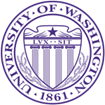

In [62]:
df = df.drop(df[df['NumberofBuildings'] > 100].index)

In [63]:
# Buildings have negative ElectricityProp
df_raw[df_raw['ElectricityProp'] < 0]

OSEBuildingID  DataYear    BuildingType          PrimaryPropertyType  \
3206          49784      2016  NonResidential  Small- and Mid-Sized Office   

        PropertyName              Address     City State  ZipCode  \
3206  Bullitt Center  1501 E. Madison St.  Seattle    WA  98122.0   

     TaxParcelIdentificationNumber  CouncilDistrictCode Neighborhood  \
3206                    7234600195                    3      CENTRAL   

      Latitude  Longitude  YearBuilt  NumberofBuildings  NumberofFloors  \
3206  47.61432 -122.31257       2013                1.0               6   

      PropertyGFATotal  PropertyGFAParking  PropertyGFABuilding(s)  \
3206             52000                   0                   52000   

     ListOfAllPropertyUseTypes LargestPropertyUseType  \
3206                    Office                 Office   

      LargestPropertyUseTypeGFA  ... SiteEUI(kBtu/sf)  SiteEUIWN(kBtu/sf)  \
3206                    48159.0  ...              7.1                 5.0   

     SourceEUI(kBtu/sf)  SourceEUIWN(kBtu/sf) SiteEnergyUse(kBtu)  \
3206                2.0                  -2.1         342726.0938   

      SiteEnergyUseWN(kBtu)  SteamUse(kBtu)  Electricity(kWh)  \
3206            240132.0938             0.0      -33826.80078   

      Electricity(kBtu)  NaturalGas(therms)  NaturalGas(kBtu)  DefaultData  \
3206          -115417.0                 0.0               0.0        False   

      Comments  ComplianceStatus  Outlier  TotalGHGEmissions  \
3206       NaN         Compliant      NaN               -0.8   

      GHGEmissionsIntensity  distance(km)  streetType ElectricityProp  \
3206                  -0.02      1.913041      street       -0.336762   

     NaturalGasProp  SteamProp  OtherEnergyProp  
3206            0.0        0.0         1.336762  

[1 rows x 52 columns]

Negative GHG emission and electricity use correspond to the use of solar pannels (<a href=https://bullittcenter.org/visit/>see</a>).

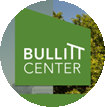

Thus this value is atypical and is **removed**.

In [64]:
df = df.drop(df[df['ElectricityProp'] < 0].index)

Some samples have **0 number of buildings and floors** which is not possible

In [65]:
df[(df['NumberofFloors'] == 0) | (df['NumberofBuildings'] == 0)]['NumberofFloors'].count()

66

As the vast majority of buildings have a number of buildings equal to 1, it is the value choosen to replace zeros

In [66]:
df.loc[df['NumberofBuildings'] == 0, 'NumberofBuildings'] = 1

The correlation between the Number of floors and GFA is evaluated with the **Pearson Coefficient**.

In [67]:
from scipy.stats import pearsonr
pearsonr(df['NumberofFloors'], df['PropertyGFABuilding(s)']) # showing link between Number of floors and GFA

(0.6055783010796936, 4.1574957951952375e-165)

As a relatively important correlation is observed, an IterativeImputer is used to estimate the number of floors based on GFA for missing values.

In [68]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

Text(0.5, 1.0, 'Buildings GFA depending on the number of floors')

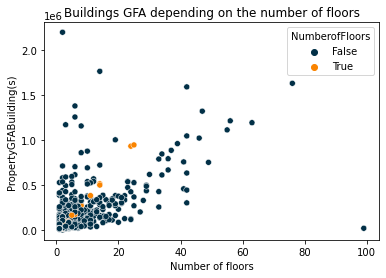

In [79]:
nb_floors = list(map(int,IterativeImputer(missing_values = 0).fit_transform(df[['NumberofFloors', 'PropertyGFABuilding(s)']])[:,0]))
fig, ax = plt.subplots()
sns.scatterplot(data = df,
                x = nb_floors,
                y = 'PropertyGFABuilding(s)',
                hue = (df['NumberofFloors'] == 0),
                palette = [c_0, c_1],
                ax = ax)
ax.set_xlabel('Number of floors')
ax.set_title('Buildings GFA depending on the number of floors')


In [80]:
df['Imp_NumberofFloors'] = nb_floors
df = df.drop(['NumberofFloors'], axis = 1)

All outsiders have been processed

## 4. Correlation between multiple features and the targets after cleaning

The possible influence of several features on the two targets (energy use and GHG emission) have been assessed graphically. This study could give a first hint on the importance of some features in the prediction of the targets.

There could be an influence on SiteEnergyUse(kBtu) of:
- NumberofBuildings with PropertyGFABuilding(s) and number of buildings in logs

<AxesSubplot:xlabel='PropertyGFABuilding(s)', ylabel='SiteEnergyUse(kBtu)'>

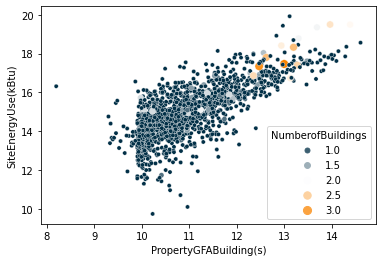

In [81]:
sns.scatterplot(x = np.log1p(df['PropertyGFABuilding(s)']),
               y = np.log1p(df['SiteEnergyUse(kBtu)']),
               hue = np.log1p(df['NumberofBuildings']),
               size = np.log1p(df['NumberofBuildings']),
               palette = custom_cmp2)

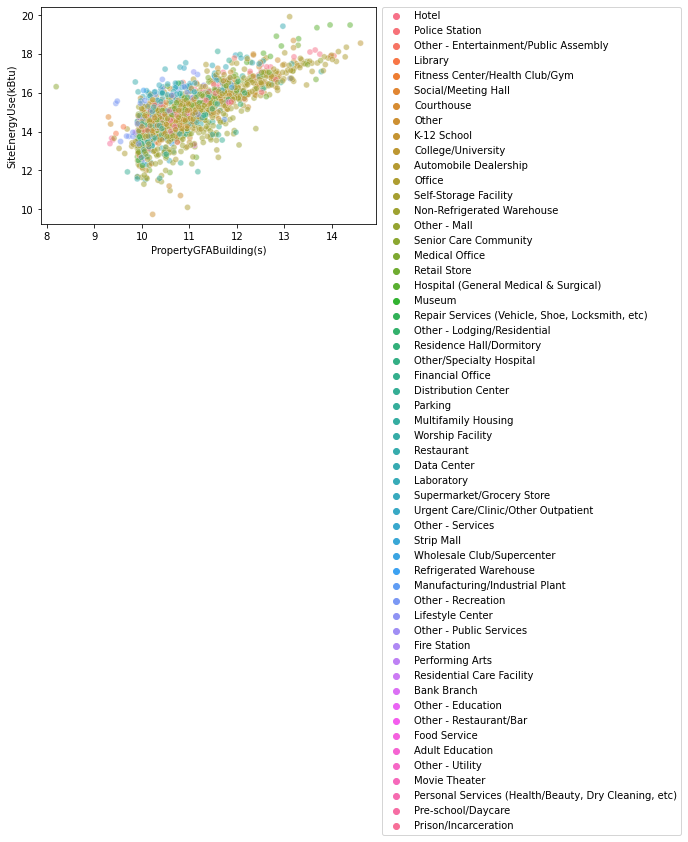

In [82]:
sns.scatterplot(x = np.log1p(df['PropertyGFABuilding(s)']),
            y = np.log1p(df['SiteEnergyUse(kBtu)']),
            hue = df['LargestPropertyUseType'],
            alpha = 0.5)

plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)

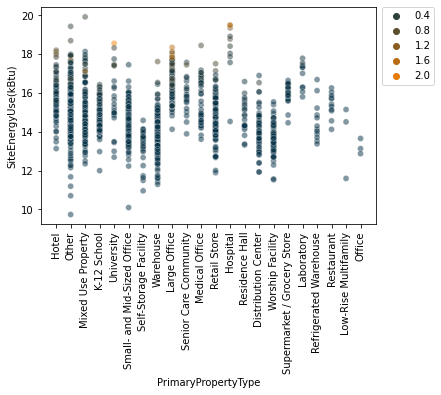

In [83]:
sns.scatterplot(x = df['PrimaryPropertyType'],
               y = np.log1p(df['SiteEnergyUse(kBtu)']),
               hue = df['PropertyGFABuilding(s)'],
               alpha = 0.5,
               palette = custom_cmp1)
plt.xticks(rotation = 90)
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)

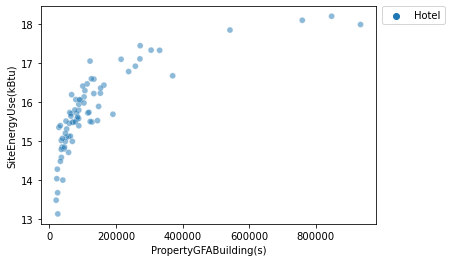

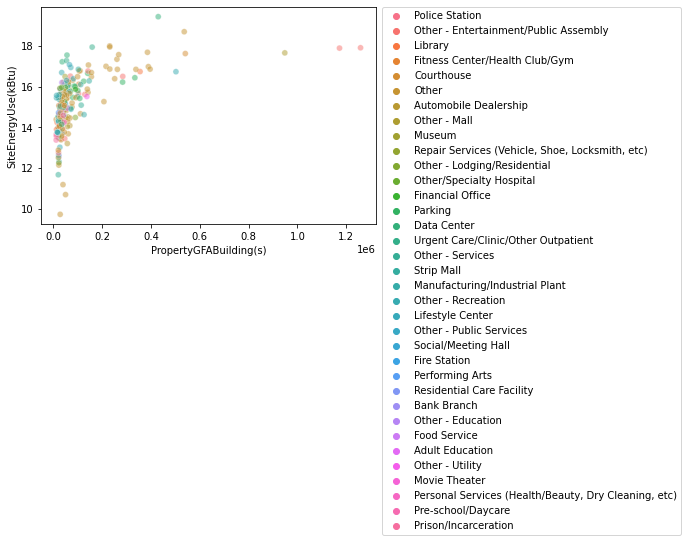

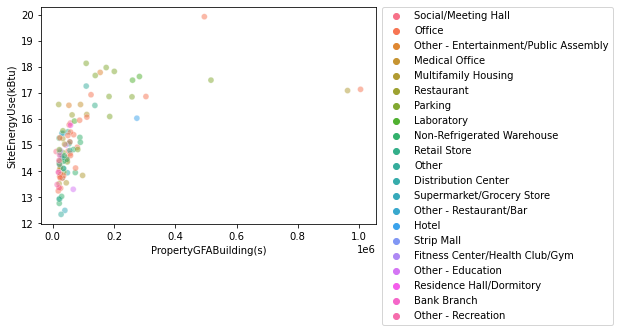

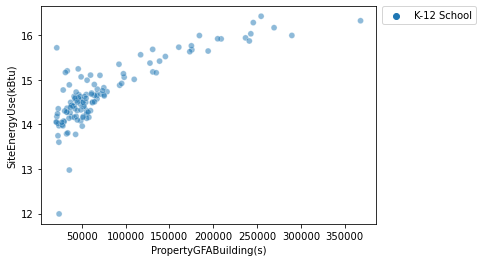

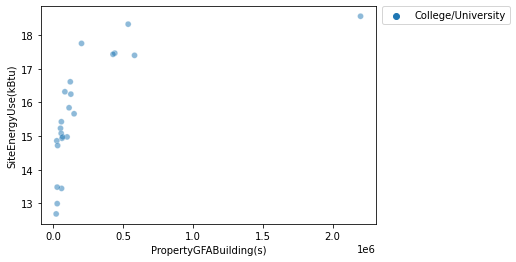

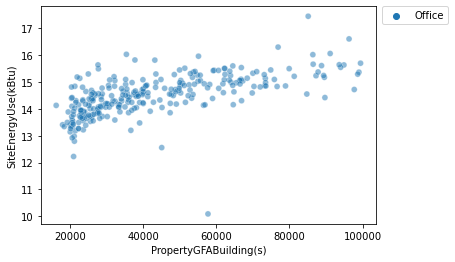

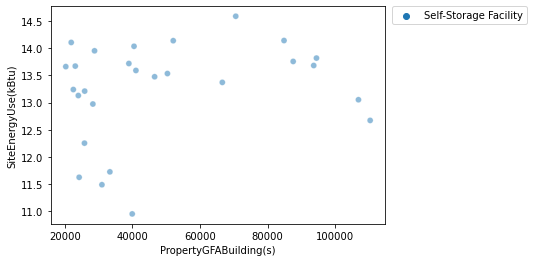

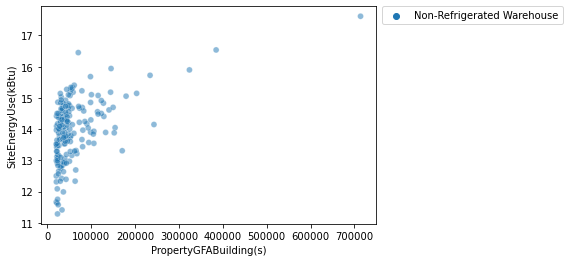

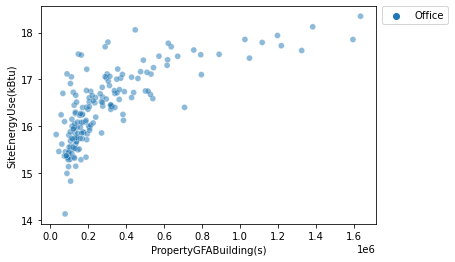

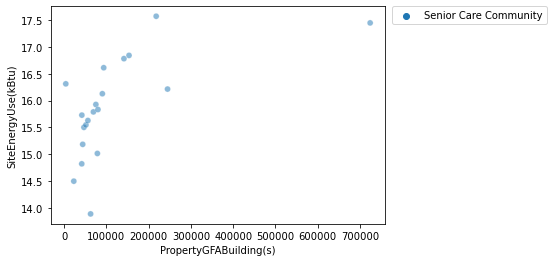

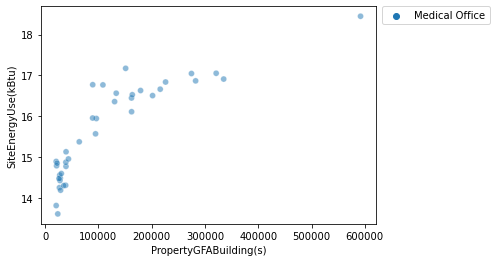

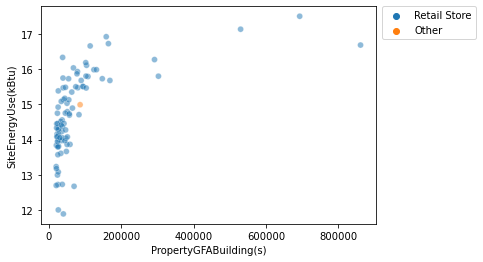

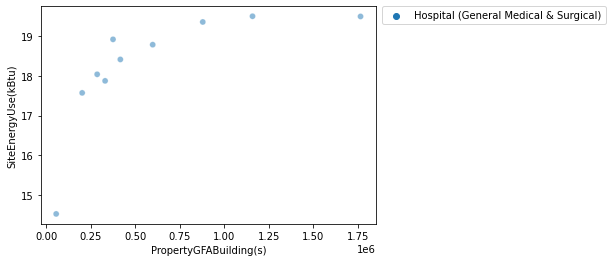

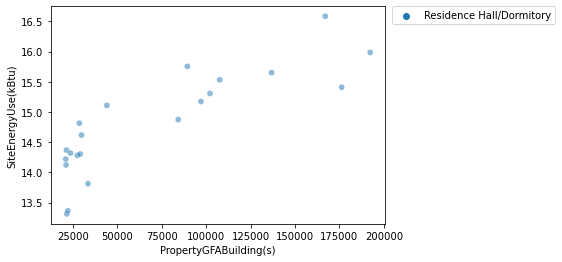

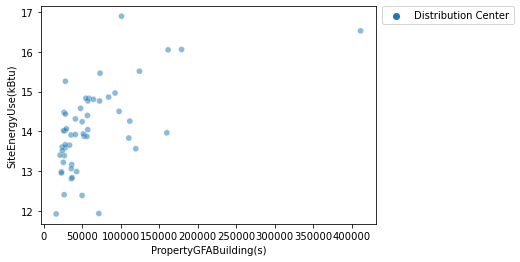

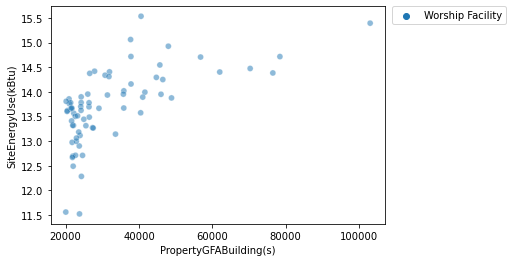

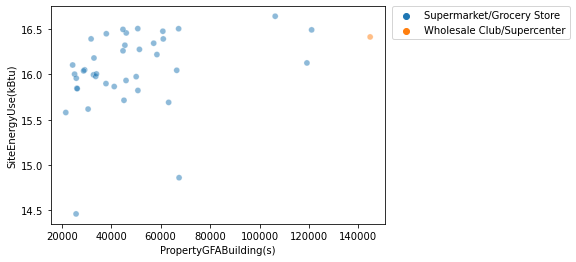

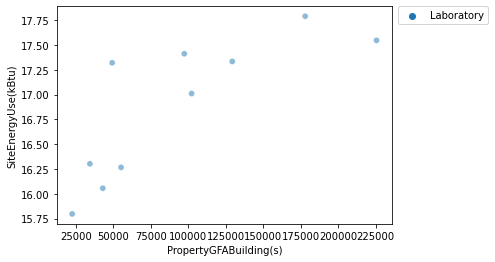

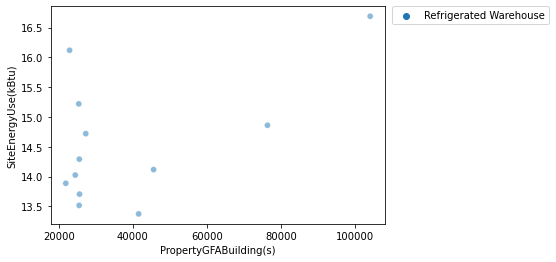

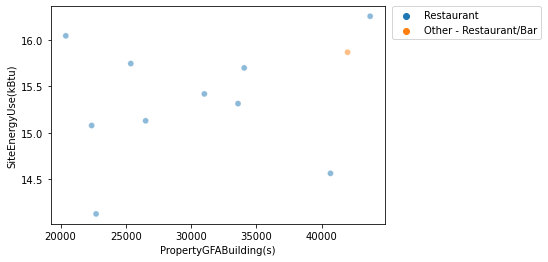

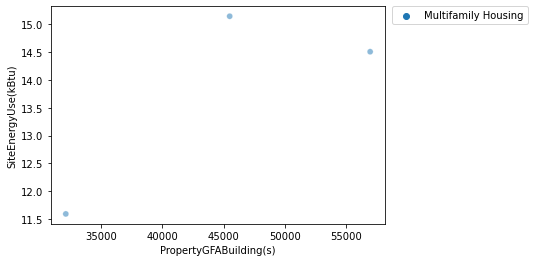

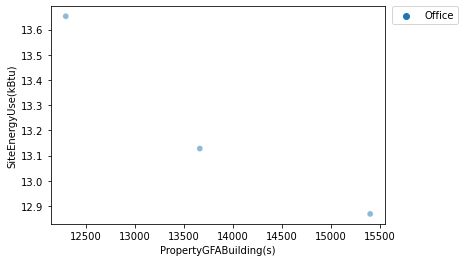

In [84]:
for prop_type in df['PrimaryPropertyType'].unique():

    sns.scatterplot(x = df.loc[df['PrimaryPropertyType'] == prop_type, 'PropertyGFABuilding(s)'],
                   y = np.log1p(df['SiteEnergyUse(kBtu)']),
                   hue = df.loc[df['PrimaryPropertyType'] == prop_type, 'LargestPropertyUseType'],
                   alpha = 0.5)
    plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
    plt.show()

# 5. Export of the data

**In the end, the following data are removed from the cleaned dataset :**


**Redundant**
- Latitude
- Longitude
- PropertyGFATotal
- LargestPropertyUseTypeGFA
- SiteEUI(kBtu/sf)
- SiteEUIWN(kBtu/sf)
- SourceEUIWN(kBtu/sf)
- SiteEnergyUseWN(kBtu)
- Electricity(kWh)
- NaturalGas(therms)
- GHGEmissionsIntensity


*Causing data leakage*
- SteamUse(kBtu)
- Electricity(kBtu)
- NaturalGas(kBtu)
- ComplianceStatus
- SourceEUI(kBtu/sf)
- GHGEmissionsIntensity


**Empty**
- Comments
- Outlier


**Not considered usefull**
- OSEBuildingID
- DataYear
- PropertyName
- Address
- City
- State
- ZipCode
- TaxParcelIdentificationNumber
- CouncilDistrictCode
- ListOfAllPropertyUseTypes
- YearsENERGYSTARCertified
- DefaultData




In [85]:
selected_features = ['BuildingType',
                     'PrimaryPropertyType',
                     'Neighborhood',
                     'YearBuilt',
                     'NumberofBuildings',
                     'PropertyGFAParking',
                     'PropertyGFABuilding(s)',
                     'LargestPropertyUseType',
                     'SecondLargestPropertyUseType',
                     'SecondLargestPropertyUseTypeGFA',
                     'ThirdLargestPropertyUseType',
                     'ThirdLargestPropertyUseTypeGFA',
                     'ENERGYSTARScore',
                     'SiteEnergyUse(kBtu)',
                     'TotalGHGEmissions',
                     'distance(km)',
                     'streetType',
                     'ElectricityProp',
                     'NaturalGasProp',
                     'SteamProp',
                     'OtherEnergyProp',
                     'Imp_NumberofFloors']

df = df[selected_features]

In [86]:
# data are exported for further investigation
df.to_csv('cleaned_df.csv', index = False)